## Quotations indicate the career success of public figures
**ChillDataGroup: Zihan Wu, Yinhao Wang, Yihang Chen**

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Load QuoteBank Dataset
We refer to the pipeline provided in Google Colab to load the quotations from 2015 to 2020.

Due to the large size of data, when loading them, we just load the data said by the senate election since 2015 candidates. The dataset for senate elections is obtained from MIT Election Data and Science Lab [1].

We also provide the codes for loading these senate candidate quotations below, but those are run ahead in google colab (takes around 30min for each year's data). We did not re-run them here. It contains the senate election results for all candidates

[1] MIT Election Data and Science Lab, 2017, "U.S. Senate 1976–2020", https://doi.org/10.7910/DVN/PEJ5QU, Harvard Dataverse, V5.

In [2]:
# Pipeline obtained from the course google colab
from tld import get_tld

def get_domain(url):
    res = get_tld(url, as_object=True)
    return res.tld

In [3]:
# Load the Senate Election Result data 
import pandas as pd
senate_file = 'SenateData/1976-2020-senate.csv'
senate_election = pd.read_csv(senate_file, encoding= 'unicode_escape')
senate_election.sample(4) # demonstrate the format of election data

,year,state,state_po,state_fips,state_cen,state_ic,office,district,stage,special,candidate,party_detailed,writein,mode,candidatevotes,totalvotes,unofficial,version,party_simplified
908,1990,COLORADO,CO,8,84,62,US SENATE,statewide,gen,False,JOHN HECKMAN,CONCERNS OF PEOPLE,False,total,15432,1022027,False,20210114,OTHER
301,1980,CONNECTICUT,CT,9,16,1,US SENATE,statewide,gen,False,GERARD G. BRENNAN,LIBERTARIAN,False,total,5336,1356075,False,20210114,LIBERTARIAN
855,1988,NORTH DAKOTA,ND,38,44,36,US SENATE,statewide,gen,False,KENNETH C. GARDNER,LIBERTARIAN,False,total,4334,289170,False,20210114,LIBERTARIAN
1992,2004,CONNECTICUT,CT,9,16,1,US SENATE,statewide,gen,False,CHRISTOPHER J. DODD,DEMOCRAT,False,total,945347,1424726,False,20210114,DEMOCRAT


Here, we only choose the candidate running for elections since 2016, because the supported Quotebank data goes back to 2015

In [4]:
# Load the names of candidates since 2016
# The NaN names are dropped, and repeated names are dropped
def delete_middle_name(name): # delete middle name
  name_split = name.upper().split()
  if len(name_split) > 2:
    senate_delete_middle_name = name_split[0] + ' ' + name_split[-1]
    return senate_delete_middle_name
  return name

# To address the variation of names, we use this function to determine whether the speaker name matches the first and 
# last name of any senate candidates. In this way, we can find speakers with different name writing style like:
# 'Senate Lindsey Graham', 'Lindsey Olin Graham', 'Lindsey O. Graham' (they all indicate the same candidate)

# The function below takes in a speaker name and a list of senate names (already split into first and last name)
# It returns a boolean whether the speaker is a senate, and the name of senate (in the form of first + last name) if true
def isSenate(name,senate_names):
  name_set = set(name.upper().split())
  for i in range(len(senate_names)):
    if senate_names[i] <= name_set:
      return (True, i)
  return (False, None)

senate_candidates = senate_election[senate_election['year'] >= 2016].dropna(subset=['candidate', 'party_detailed'])['candidate'].unique()
senate_candidates_splitted = list(map(lambda senate: set(delete_middle_name(senate).split()), senate_candidates))
senate_candidates_splitted[1:10]

[{'RICHARD', 'SHELBY'},
 {'JOE', 'MILLER'},
 {'GIANOUTSOS', 'TED'},
 {'METCALFE', 'RAY'},
 {'MARGARET', 'STOCK'},
 {'BRECK', 'CRAIG'},
 {'LISA', 'MURKOWSKI'},
 {'ANTHONY', 'CAMBONI'},
 {'ANN', 'KIRKPATRICK'}]

In [5]:
#Sanity Check: all names at least have a first and last name
for split in senate_candidates_splitted:
    assert(len(split) > 1)
print('there are total {} names'.format(len(senate_candidates_splitted)))

there are total 439 names


**We do not run the cell below because takes too long.** We have run those on google colab to load the quotation data we need

In [6]:
%%script echo skipping
# Load each year's data, filtering out the quotations said by senates
# We have considered the different writing styles of name. We extract the quote as long as the speaker has the same
# first name and last name as a senate
import bz2
import json

path_to_file = '/content/drive/MyDrive/Quotebank/quotes-{}.json.bz2' 
path_to_out = '/content/drive/MyDrive/MyQuoteBank/quotes-{}-senates-said.json.bz2'

for year in range(2015, 2021):
  print('... Start reading quotations in year ' + str(year))
  with bz2.open(path_to_file.format(year), 'rb') as s_file:
      with bz2.open(path_to_out.format(year), 'wb') as d_file:
          for instance in s_file:
              instance = json.loads(instance) # loading a sample
              issenate = isSenate(instance['speaker'], senate_candidates_splitted)
              if issenate[0]:
                instance['speaker'] = senate_candidates[issenate[1]] # use name from the "1976-2020-senate.csv" as the standard name.
                urls = instance['urls'] # extracting list of links
                domains = []
                for url in urls:
                    tld = get_domain(url)
                    domains.append(tld)
                instance['domains'] = domains # updating the sample with domain name
                d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file

# Load each year's data, filtering out the quotations that mention senates
path_to_file = '/content/drive/MyDrive/Quotebank/quotes-{}.json.bz2'
path_to_out = '/content/drive/MyDrive/ADAQuoteBank/quotes-{}-senates-mention.json.bz2'

senate_candidates = list(map(lambda x:x.title(), senate_candidates))

for year in range(2016,2021):
    print('... Start processing quotations in year {}'.format(year))
    with bz2.open(path_to_file.format(year), 'rb') as s_file:
        with bz2.open(path_to_out.format(year), 'wb') as d_file:
            for instance in s_file:
                instance = json.loads(instance)
                is_senate = isSenate(instance['quotation'], senate_candidates_splitted)
                if is_senate[0]:
                    instance['mention']=senate_candidates[is_senate[1]]
                    urls = instance['urls'] # extracting list of links
                    domains = []
                    for url in urls:
                        tld = get_domain(url)
                        domains.append(tld)
                    instance['domains'] = domains # updating the sample with domain name
                    d_file.write((json.dumps(instance)+'\n').encode('utf-8'))
    print('... End processing quotations in year {}'.format(year))

skipping


## 1. Process Senate Candidate Data
**1.1** In this section, we load the information of senate candidates (since 2016) and their election information.

In [7]:
# First, we get the election information of the candidates since 2016 (again, we drop NaN and repeated names)
candidate_info = senate_election[senate_election['year'] >= 2016].dropna(subset=['candidate', 'party_detailed']).drop_duplicates(subset=['candidate'], ignore_index=True)

In [8]:
# Load the stored quotations said by senate candidates since 2015 (by year)
senate_quote_20 = pd.read_json('SenateData/quotes-2020-senates-said.json.bz2', lines=True, compression='bz2')
senate_quote_19 = pd.read_json('SenateData/quotes-2019-senates-said.json.bz2', lines=True, compression='bz2')
senate_quote_18 = pd.read_json('SenateData/quotes-2018-senates-said.json.bz2', lines=True, compression='bz2')
senate_quote_17 = pd.read_json('SenateData/quotes-2017-senates-said.json.bz2', lines=True, compression='bz2')
senate_quote_16 = pd.read_json('SenateData/quotes-2016-senates-said.json.bz2', lines=True, compression='bz2')
senate_quote_15 = pd.read_json('SenateData/quotes-2015-senates-said.json.bz2', lines=True, compression='bz2')

In [9]:
# Concatenate data across all years and display the format of quotation data
annual_frames = [senate_quote_15, senate_quote_16, senate_quote_17, senate_quote_18, senate_quote_19, senate_quote_20]
candidate_quotes = pd.concat(annual_frames).reset_index()
candidate_quotes.sample(4)

,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains
114032,114032,2015-02-11-030497,I haven't had a chance to review the transcrip...,MARCO RUBIO,[Q324546],2015-02-11 11:00:03,1,"[[Marco Rubio, 0.6606], [None, 0.2218], [Jerry...",[http://thehill.com/homenews/campaign/232394-c...,E,[com]
715797,160855,2018-09-14-041150,"I reach out with my own feelings, and hope and...",MITT ROMNEY,[Q4496],2018-09-14 17:35:00,1,"[[Mitt Romney, 0.6242], [None, 0.3758]]",[https://www.deseretnews.com/article/900031908...,E,[com]
858951,50498,2019-11-01-119608,Women are really penalized. Whether someone is...,KIRSTEN E. GILLIBRAND,[Q22222],2019-11-01 05:22:39,1,"[[Kirsten Gillibrand, 0.518], [None, 0.482]]",[https://thehoya.com/kirsten-gillibrand/],E,[com]
63606,63606,2015-04-14-000827,a leader from yesterday... promising to take u...,MARCO RUBIO,[Q324546],2015-04-14 00:37:00,9,"[[Marco Rubio, 0.4013], [None, 0.332], [Hillar...",[http://www.baltimoresun.com/news/nation-world...,E,"[com, com, com, com, com, com, com, com]"


Since QuoteBank may extract different number of total quotes at different time. An increase in quotations may just be caused by an increase of quotes extracted by Quotebanks. So, we use the total quotation number in QuoteBank to normalize our data

In [10]:
# read the quote number data for each month

import csv
with open('SenateData/quote_num.csv','r') as inFile:
    reader = csv.DictReader(inFile)
    for row in reader:
        quote_num = dict(row)
quote_num = pd.Series({k:int(v) for k, v in quote_num.items()})
quote_num

2015-01    1661137
2015-02    1659518
2015-03    1867911
2015-04    1522315
2015-05    1136152
            ...   
2019-12    1565321
2020-01    1732238
2020-02    1599019
2020-03    1323347
2020-04     589845
Length: 64, dtype: int64

In [11]:
# we use 10^6/total_quote_num as normalize factor

candidate_quotes['normalize_factor'] = candidate_quotes['date'].map(lambda x: 1/quote_num[str(x)[:7]]*1e6)
candidate_quotes['normalize_quotes'] = candidate_quotes['numOccurrences']*candidate_quotes['normalize_factor']
candidate_quotes.sample(4)

,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains,normalize_factor,normalize_quotes
936314,127861,2019-11-25-050946,Jodey is a friend and a strong leader for West...,TED CRUZ,[Q2036942],2019-11-25 01:00:45,1,"[[Ted Cruz, 0.7254], [None, 0.2043], [Mike Con...",[https://kfyo.com/jodey-arrington-announces-re...,E,[com],0.542426,0.542426
864281,55828,2019-07-15-005671,"AOC and this crowd are a bunch of communists,",LINDSEY GRAHAM,[Q22212],2019-07-15 15:37:18,1,"[[Lindsey Graham, 0.9407], [None, 0.0593]]",[https://www.theblaze.com/news/lindsay-graham-...,E,[com],0.668486,0.668486
73370,73370,2015-04-10-053021,My goal is to make sure that we go after those...,LINDSEY GRAHAM,[Q22212],2015-04-10 21:51:52,5,"[[Lindsey Graham, 0.5219], [None, 0.1965], [Mi...",[http://www.washingtontimes.com/news/2015/apr/...,E,"[com, com, com, com.au, com.au]",0.656894,3.284471
358707,44309,2017-05-17-092180,reaching the point where it's of Watergate siz...,JOHN MCCAIN,[Q10390],2017-05-17 00:00:00,4,"[[John McCain, 0.766], [None, 0.1387], [Lawren...",[http://news.sky.com/story/could-donald-trump-...,E,"[com, com, com, com]",0.401338,1.605352


**1.2** We group the total number of quotations by speaker and dates. By doing so, we can visualize the change of quoted numbers as time goes on. Below, we take Bernie Sanders as an example.

In [12]:
# Clean the names by taking only upper case
# Group the candidate total number of normalized quotes by day
candidate_quotes['speaker'] = candidate_quotes['speaker'].str.upper()
candidate_quotes['date_only'] = candidate_quotes['date'].dt.date
candidate_quotes_byday = candidate_quotes.groupby(['speaker', 'date_only'])['normalize_quotes'].sum()
candidate_quotes_byday

speaker           date_only 
A. WAYNE JOHNSON  2015-01-06    0.601997
                  2015-02-09    0.602585
                  2015-02-11    1.205169
                  2015-02-20    0.602585
                  2015-03-01    0.535357
                                  ...   
ZAK RINGELSTEIN   2018-10-30    5.125275
                  2018-11-01    2.381878
                  2018-11-05    0.476376
                  2018-11-07    0.476376
                  2019-03-21    0.503878
Name: normalize_quotes, Length: 136070, dtype: float64

Text(0.5, 1.0, 'Bernie Sanders')

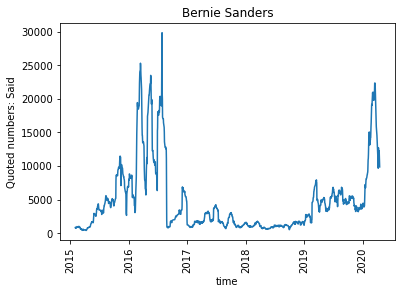

In [13]:
# For example, we can visualize the quotation changes of Bernie Sanders
candidate_quotes_byday['BERNIE SANDERS'].rolling(window=30).sum().plot() # one months average
plt.xlabel('time')
plt.xticks(rotation=90)
plt.ylabel('Quoted numbers: Said')
plt.title('Bernie Sanders')

**1.3** We compute the total number of quotations until their election. The election dataset only contains the year of election. However, since the U.S. Senate elections always take place in the first week of November, we just compute the total number of quotations until November.1st of the election year.

In [14]:
# Add the election day corresponding to each candidate speaker
candidate_info_byname = candidate_info.set_index(['candidate']) # Allow access info by name as index
candidate_quotes['election_day'] = candidate_quotes['speaker'].map(candidate_info_byname['year']).astype(str)+ '-11-01'
candidate_quotes['election_day'] = pd.to_datetime(candidate_quotes['election_day'])

In [15]:
# Add election result (i.e. vote rate) for each candidate speaker
candidate_info_byname['vote_rate'] = candidate_info_byname['candidatevotes']/candidate_info_byname['totalvotes']

In [16]:
# We group the number of quotations by election day
quotes_byelection = candidate_quotes[candidate_quotes['date_only'] < candidate_quotes['election_day']]
tot_quotes_byelection = pd.DataFrame(quotes_byelection.groupby(['speaker'])['normalize_quotes'].sum())
tot_quotes_byelection.rename(columns = {'normalize_quotes': 'total_quotes_byelection'}, inplace=True)

Pearson coefficient: 0.6112235983030401, p value: 3.506776291721692e-26


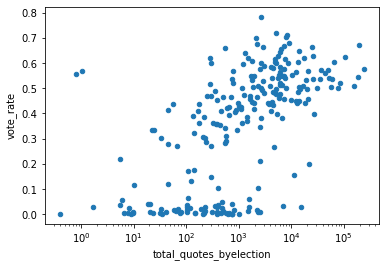

In [17]:
# We add the vote rate and plot the scatter plot of vote rate against total quotes by election
from scipy.stats import pearsonr
tot_quotes_byelection['vote_rate'] = tot_quotes_byelection.index.map(candidate_info_byname['vote_rate'])
quotes_vote = tot_quotes_byelection.plot.scatter(x = 'total_quotes_byelection', y = 'vote_rate', logx=True)
(corr1, pvalue) = pearsonr(np.log(tot_quotes_byelection['total_quotes_byelection']), tot_quotes_byelection['vote_rate'])
print(f'Pearson coefficient: {corr1}, p value: {pvalue}')

**Observation**: Based on the plot above, we can see that there is a positive correlation between quotations and vote_rate with p value < 0.05. The more a candidate was quoted before the election, the higher the voting rate he or she got.

**1.4** We can also apply the analysis on quotations that mention senates.

In [18]:
# Load the stored quotations mention senate candidates since 2015 (by year)
senate_quote_20_mention = pd.read_json('SenateData/quotes-2020-senates-mention.json.bz2', lines=True, compression='bz2')
senate_quote_19_mention = pd.read_json('SenateData/quotes-2019-senates-mention.json.bz2', lines=True, compression='bz2')
senate_quote_18_mention = pd.read_json('SenateData/quotes-2018-senates-mention.json.bz2', lines=True, compression='bz2')
senate_quote_17_mention = pd.read_json('SenateData/quotes-2017-senates-mention.json.bz2', lines=True, compression='bz2')
senate_quote_16_mention = pd.read_json('SenateData/quotes-2016-senates-mention.json.bz2', lines=True, compression='bz2')
senate_quote_15_mention = pd.read_json('SenateData/quotes-2015-senates-mention.json.bz2', lines=True, compression='bz2')

In [19]:
# Concatenate data across all years and display the format of quotation data
annual_frames_mention = [senate_quote_15_mention, senate_quote_16_mention, senate_quote_17_mention, senate_quote_18_mention, senate_quote_19_mention, senate_quote_20_mention]
candidate_quotes_mention = pd.concat(annual_frames_mention)
candidate_quotes_mention.sample(4)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,mention,domains
1670,2015-08-06-081095,Prosecutors have charged several top aides to ...,Jim Clyburn,[Q1289889],2015-08-06 11:57:21,1,"[[Jim Clyburn, 0.4641], [None, 0.3354], [RON P...",[http://www.politico.com/huddle/0815/huddle194...,E,Rand Paul,[com]
4403,2018-01-24-134402,Tom Young told Steven Aiello that Todd Howe wa...,None,[],2018-01-24 06:47:17,1,"[[None, 0.4932], [Tom Young, 0.2728], [Mario C...",[http://www.syracuse.com/state/index.ssf/2018/...,E,Todd C. Young,[com]
13798,2019-09-24-006993,Are we still that country anymore? Did John F....,Jim Acosta,[Q6193301],2019-09-24 18:15:00,1,"[[Jim Acosta, 0.8844], [None, 0.1156]]",[https://www.newsbusters.org/blogs/nb/tim-grah...,E,John Kennedy,[org]
10101,2015-08-15-031668,It recognizes that James Smith carried out a v...,Nathan Smith,"[Q18088901, Q1966636, Q1966650, Q24005445, Q24...",2015-08-15 06:27:48,2,"[[Nathan Smith, 0.5826], [None, 0.3525], [John...",[http://nwaonline.com/news/2015/aug/15/springd...,E,John James,"[com, com]"


In [20]:
# format the date
candidate_quotes_mention['date_only'] = candidate_quotes_mention['date'].dt.date
# change the name to upper format
candidate_quotes_mention['mention'] = candidate_quotes_mention['mention'].str.upper()

# Normalize the quotes
candidate_quotes_mention['normalize_factor'] = candidate_quotes_mention['date'].map(lambda x: 1/quote_num[str(x)[:7]]*1e6)
candidate_quotes_mention['normalize_quotes'] = candidate_quotes_mention['numOccurrences']*candidate_quotes_mention['normalize_factor']
candidate_quotes_mention.sample(5)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,mention,domains,date_only,normalize_factor,normalize_quotes
6651,2018-01-18-132581,Trump has always had an identity that is disti...,None,[],2018-01-18 11:00:13,1,"[[None, 0.5583], [Michael Steel, 0.4086], [Pre...",[http://thehill.com/homenews/campaign/369474-g...,E,MARCO RUBIO,[com],2018-01-18,0.402250,0.402250
7893,2017-02-16-059770,Last time I was warning Republicans that Tammy...,Scott Jensen,"[Q14948804, Q28018199]",2017-02-16 20:30:00,2,"[[Scott Jensen, 0.7089], [None, 0.2496], [Tamm...",[http://host.madison.com/wsj/news/local/govt-a...,E,TAMMY BALDWIN,"[com, com]",2017-02-16,1.040036,2.080072
2199,2020-01-22-010514,Bernie Sanders Hits Joe Biden on Social Securi...,None,[],2020-01-22 05:00:00,2,"[[None, 0.7921], [Bernie Sanders, 0.1251], [Jo...",[https://www.commondreams.org/views/2020/01/22...,E,BERNIE SANDERS,[org],2020-01-22,0.577288,1.154576
9259,2017-07-24-098734,Ted Cruz has a strong grass roots following in...,None,[],2017-07-24 23:40:00,1,"[[None, 0.8544], [Ted Cruz, 0.1456]]",[http://www.gwinnettdailypost.com/local/ted-cr...,E,TED CRUZ,[com],2017-07-24,0.418827,0.418827
2228,2020-04-15-007015,Bernie Sanders will use his campaign's live st...,Bernie Sanders,[Q359442],2020-04-15 00:00:00,1,"[[Bernie Sanders, 0.5605], [None, 0.3491], [Jo...",[https://www.foxnews.com/politics/bleak-march-...,E,BERNIE SANDERS,[com],2020-04-15,1.695361,1.695361


In [21]:
# obtain normalized quotations by day
candidate_quotes_mention_byday = candidate_quotes_mention.groupby(['mention', 'date_only'])['normalize_quotes'].sum()
candidate_quotes_mention_byday

mention           date_only 
A. WAYNE JOHNSON  2015-01-16    0.601997
                  2015-08-04    0.473512
                  2015-12-11    0.955093
                  2017-02-12    2.080072
                  2017-05-28    0.401338
                                  ...   
WILLIE L. WILSON  2019-03-30    0.503878
                  2019-07-16    0.668486
                  2019-11-04    0.542426
ZAK RINGELSTEIN   2018-06-22    0.482000
                  2018-10-24    0.427106
Name: normalize_quotes, Length: 34904, dtype: float64

Text(0.5, 1.0, 'Bernie Sanders')

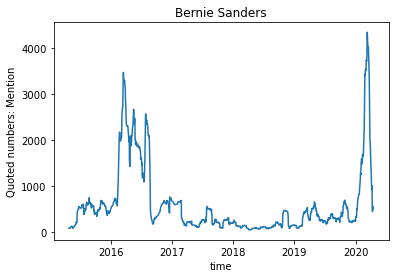

In [22]:
# For example, we can visualize the quotation changes of Bernie Sanders
candidate_quotes_mention_byday['BERNIE SANDERS'].rolling(window=30).sum().plot() # one months average
plt.xlabel('time')
plt.ylabel('Quoted numbers: Mention')
plt.title('Bernie Sanders')

In [23]:
# Add the election day corresponding to each candidate mentioned
candidate_info_byname = candidate_info.set_index(['candidate']) # Allow access info by name as index
candidate_quotes_mention['mention']=candidate_quotes_mention.mention.map(lambda x:x.upper())
candidate_quotes_mention['election_day'] = candidate_quotes_mention['mention'].map(candidate_info_byname['year']).astype(str)+ '-11-01'
candidate_quotes_mention['election_day'] = pd.to_datetime(candidate_quotes_mention['election_day'])
candidate_quotes_mention.head(4)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,mention,domains,date_only,normalize_factor,normalize_quotes,election_day
0,2015-05-17-016225,I really like Bernie Sanders and his policies ...,None,[],2015-05-17 07:09:22,1,"[[None, 0.81], [Bernie Sanders, 0.19]]",[http://dailykos.com/story/2015/05/15/1384917/...,E,BERNIE SANDERS,[com],2015-05-17,0.880164,0.880164,2018-11-01
1,2015-08-25-018582,Elizabeth Warren does have a thumb on the puls...,Bakari Sellers,[Q4849014],2015-08-25 10:02:35,4,"[[Bakari Sellers, 0.8813], [None, 0.1075], [El...",[http://www.kspr.com/news/politics/does-elizab...,E,ELIZABETH A. WARREN,"[com, com, com, com]",2015-08-25,0.473512,1.894046,2018-11-01
2,2015-03-11-040221,I'll invoke the marital privilege on some of i...,Mike Coffman,[Q547218],2015-03-11 17:09:31,1,"[[Mike Coffman, 0.4786], [None, 0.3104], [Tom ...",[http://www.huffingtonpost.com/jason-salzman/r...,E,CORY GARDNER,[com],2015-03-11,0.535357,0.535357,2020-11-01
3,2015-09-24-081451,Richard Burr truly is North Carolina's `Invisi...,None,[],2015-09-24 02:04:45,1,"[[None, 0.7571], [Richard Burr, 0.182], [Paul ...",[http://www.wcti12.com/news/Ross-leaves-job-po...,E,RICHARD BURR,[com],2015-09-24,0.447555,0.447555,2016-11-01


Pearson coefficient: 0.5320764453359699, p value: 1.1343252830666171e-22


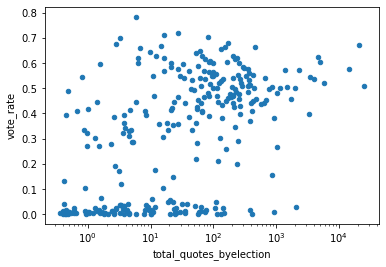

In [24]:
from scipy.stats import pearsonr

# Add election result (i.e. vote rate) for each candidate speaker
candidate_info_byname['vote_rate'] = candidate_info_byname['candidatevotes']/candidate_info_byname['totalvotes']

# We group the number of normalized quotations before election day
quotes_byelection = candidate_quotes_mention[candidate_quotes_mention['date_only'] < candidate_quotes_mention['election_day']]
tot_quotes_byelection = pd.DataFrame(quotes_byelection.groupby(['mention'])['normalize_quotes'].sum())
tot_quotes_byelection.rename(columns = {'normalize_quotes': 'total_quotes_byelection'}, inplace=True)

# We add the vote rate and plot the scatter plot of vote rate against total quotes by election
tot_quotes_byelection['vote_rate'] = tot_quotes_byelection.index.map(candidate_info_byname['vote_rate'])

# linear regression
quotes_vote = tot_quotes_byelection.plot.scatter(x = 'total_quotes_byelection', y = 'vote_rate', logx=True)
(corr1, pvalue) = pearsonr(np.log(tot_quotes_byelection['total_quotes_byelection']), tot_quotes_byelection['vote_rate'])
print(f'Pearson coefficient: {corr1}, p value: {pvalue}')

**Observation**: Based on the plot above, we can see that there is also a positive correlation between number of mentioned quotations and vote_rate with p value < 0.05.

## 2. Weigh the quotations by readership
We are aware of the different reading statistics of different media. We try to weigh the quotations by the readership of the source media.

**2.1** First, we sample 50k quotes and look at the source media of those quotations. This would give us a feel of how much media is covered by QuoteBank and which media appear most often. To balance the data said by candidates and the data mentioning candidates, we sample the 50k quotes according to the ratio of total data in 'candidate_quotes' and 'candidate_quotes_mention'

In [25]:
# sample 50k quotes and see where quotes are published
candidate_quotes_mention.reset_index(inplace=True) # Reset index of mention dataset
sample_n = 50000
said_n = len(candidate_quotes.index) # total number of quotes said by candidates
mention_n = len(candidate_quotes_mention.index) # total number of quotes mentioning candidates
mention_sample_n = int(sample_n * mention_n/(mention_n + said_n))
said_sample_n = sample_n - mention_sample_n
print('we sample {} quotes said by candidates and {} quotes mentioning candidates'.format(said_sample_n, mention_sample_n))

we sample 46123 quotes said by candidates and 3877 quotes mentioning candidates


In [26]:
# We extract the domains from two data set based on the ratio computed above
total_domains = []
said_sample = candidate_quotes.sample(said_sample_n) # sample from quotes said by candidates
# We extract web domains from the url
for i in said_sample.index:
    urls = said_sample.at[i,'urls']
    for url in urls: # Some URL here is actually a list (there are lists in list), not sure why it happens
        total_domains.append(get_tld(url, as_object=True).domain)

mention_sample = candidate_quotes.sample(mention_sample_n) # sample from quotes said by candidates
# We use the same pipeline to extract domain
for i in mention_sample.index:
    urls = mention_sample.at[i,'urls']
    for url in urls: # Some URL here is actually a list (there are lists in list), not sure why it happens
        total_domains.append(get_tld(url, as_object=True).domain)

We use the code below to find top 30 frequently appearing media in the sample. (Note: the last several media may be different from sample to sample, but overall they do not affect the result!)

In [27]:
# Count the frequency of media occurences in quotation dataset
from collections import Counter
domain_count = Counter(total_domains).most_common()
print("----top 30 news agency/publisher:\n ", domain_count[0:30])
print('----number of news agency covered:', len(domain_count))


----top 30 news agency/publisher:
  [('krmg', 5428), ('msn', 3041), ('news965', 2791), ('wokv', 2751), ('breitbart', 2535), ('thehill', 2442), ('businessinsider', 2366), ('washingtonexaminer', 2355), ('washingtontimes', 2066), ('einnews', 2008), ('yahoo', 1999), ('cnn', 1971), ('cbsnews', 1774), ('foxnews', 1754), ('wsbradio', 1611), ('washingtonpost', 1360), ('newsmax', 1357), ('politico', 1350), ('sfgate', 1288), ('nytimes', 1287), ('patch', 1286), ('huffingtonpost', 1280), ('nbcnews', 1103), ('kdhnews', 1041), ('news12', 1026), ('startribune', 901), ('abc-7', 853), ('wftv', 814), ('rollcall', 802), ('newsweek', 778)]
----number of news agency covered: 5065


Among 50k samples, there are over 4000 different website domains, indicating a sufficiently wide coverage of media. So the quotations can be an indicator of public exposure. Besides, we observe an exponential decrease of counts in the database.

Text(0.5, 0, 'occurences in sampled quote data')

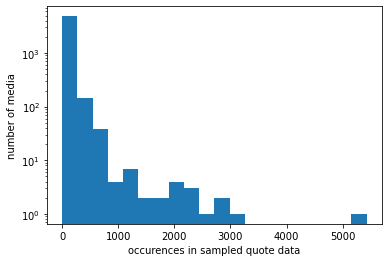

In [28]:
# Plot the histogram characterizing the frequency of each media appearing
_, y_counts = zip(*domain_count)
plt.hist(y_counts, bins=20)
plt.yscale('log')
plt.ylabel('number of media')
plt.xlabel('occurences in sampled quote data')

**Do Not Re run the cell below! In case sample changes**

10 randomly selected news agency/publisher except the top 30:

  ['bakersfield','wtkr', 'go', 'navytimes', 'advertiser-tribune', 'circleofblue', 'nbcphiladelphia', 'malaymail', 'illawarramercury', 'hawaiinewsnow']
  
The code to get the 10 random media is shown below, we comment it out because each time it selects 10 different media, which may confuse the viewer of this notebook.

In [29]:
%%script echo skipping
#media_ind = np.random.randint(31, len(domain_count), size=10)
#print("10 randomly selected news agency/publisher except the top 30:\n ", [domain_count[i] for i in media_ind])

skipping


The distribution is heavy-tailed, with only a few big media like CNN and Fox News occurring frequently. Most media occurs no more than 1.5% among all quotations. So, we think it is sufficient to just weigh the quotations extracted from those frequently occurring media. Moreover, it is very difficult to automatically find media's reading statistics (or other indicators of popularity) just based on the url major domain name. We could not think of a way to do so. Neither could we find an open dataset helping us. Therefore, we decide to manually look up the readership of those top 30 new agencies. For the rest media, we will sample 10 media from them and manually look up the reading statistics. We will take the average readership of those 10 media to represent the readership of the rest media. This will take up some time, so we plan to finish those manual work in the following weeks (see proposed timeline). As a result, we do not include any exposure level (quotation weighted by media readership) in Milestone 2. Instead, we just use the number of quotations (assuming all media offer the same public exposure).

**2.2** We manually search the total website visits of top 30 news agencies of the 10 randomly selected agencies among the rest. We could not find the data of some websites, so we use the median of others to fill it.

In [30]:
weight_file = 'SenateData/WebsiteVisit.csv'
weight_df = pd.read_csv(weight_file)
# Fill the NaN value by median (which avoid effect from outliers)
weight_df.loc[:, ['total_view_in_US']] = weight_df[['total_view_in_US']].fillna(weight_df[['total_view_in_US']].median())
weight_df.head(5) # demonstrate the format website view data for weight


,webdomain,agency,total_view_in_US,audience,source
0,KRMG,KRMG,0.11,0.033,https://webrate.org/site/krmg.com/
1,news965,WBDO,21.68,NaN,default
2,wokv,WOKV,0.09,0.046,https://webrate.org/site/wokv.com/
3,msn,MSN,323.98,194.400,default
4,breitbart,Breitbart,42.19,40.730,default


In [31]:
# Get the views for the 10 randomly selected agencies
random_file = 'SenateData/RandomVisit.csv'
random_df = pd.read_csv(random_file)
# We take the median of total_US_view of the 10 agencies, as view for other agencies
random_view = random_df['total_view_in_US'].median()
print('The median value of total views of the 10 agencies is {}'.format(random_view))

The median value of total views of the 10 agencies is 0.675


Then, we add those weights to the 'candidate_quotes' and 'candidate_quotes_mention'

In [32]:
# assign weights to quotes said by candidates
weight_dict = dict(zip(weight_df['webdomain'], weight_df['total_view_in_US']))
n_hit = 0
for i in candidate_quotes.index:
    urls = candidate_quotes.at[i,'urls']
    weight_ = 0
    for url in urls: # Some URL here is actually a list (there are lists in list), not sure why it happens
        webdomain = get_tld(url, as_object=True).domain # when it is a list, the multiply urls point to the same website
        if webdomain in weight_dict.keys():
            weight_ = weight_ + weight_dict[webdomain]
            n_hit = n_hit + 1
        else:
            weight_ = weight_ + random_view
    candidate_quotes.at[i,'views'] = weight_ 
print('For quotes said by candidates, we found {} numbers of quotation occurrences from top 30'.format(n_hit))

For quotes said by candidates, we found 1044245 numbers of quotation occurrences from top 30


In [33]:
# Multiply views by normalization factors
candidate_quotes['normalize_views'] = candidate_quotes['views']*candidate_quotes['normalize_factor']
candidate_quotes.sample(5)

,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains,normalize_factor,normalize_quotes,date_only,election_day,views,normalize_views
419143,104745,2017-07-24-079526,Nancy Pelosi desperately wants another vote fo...,MARK KELLY,"[Q10326587, Q11770303, Q22261100, Q28709861, Q...",2017-07-24 05:39:00,8,"[[Mark Kelly, 0.8318], [None, 0.1362], [Dave B...",[https://www.washingtonpost.com/local/virginia...,E,"[com, com, com, com, com, com, com, com]",0.418827,3.350618,2017-07-24,2020-11-01,124.785,52.263364
1023432,214979,2019-03-12-080762,The world has now witnessed the second tragic ...,ELIZABETH A. WARREN,[Q434706],2019-03-12 22:59:30,1,"[[Elizabeth Warren, 0.8789], [None, 0.1007], [...",[https://www.washingtonexaminer.com/news/boein...,E,[com],0.503878,0.503878,2019-03-12,2018-11-01,13.320,6.711656
114543,114543,2015-04-08-078815,"The way they do things now, because they opera...",JOHN HOEVEN,[Q374762],2015-04-08 22:31:23,3,"[[John Hoeven, 0.961], [None, 0.0391]]",[http://www.grandforksherald.com/news/local/37...,E,"[com, com, com]",0.656894,1.970683,2015-04-08,2016-11-01,2.025,1.330211
1004355,195902,2019-01-25-071200,on the wealth of the richest Americans.,ELIZABETH A. WARREN,[Q434706],2019-01-25 22:02:06,1,"[[Elizabeth Warren, 0.5235], [None, 0.4765]]",[http://thestreet.com/politics/what-is-a-wealt...,E,[com],0.520217,0.520217,2019-01-25,2018-11-01,0.675,0.351147
581367,26425,2018-02-13-075926,I've actually had several real action figures ...,DOUG JONES,"[Q1251779, Q16142774, Q30122825, Q461309, Q530...",2018-02-13 01:56:07,4,"[[Doug Jones, 0.667], [Guillermo del Toro, 0.2...",[http://www.lmtonline.com/entertainment/the-wr...,E,"[com, com, com, com]",0.401482,1.605927,2018-02-13,2020-11-01,87.055,34.950997


In [34]:
# assign weights to quotes mentioning candidates
n_hit = 0
for i in candidate_quotes_mention.index:
    urls = candidate_quotes_mention.at[i,'urls']
    weight_ = 0
    for url in urls: # Some URL here is actually a list (there are lists in list), not sure why it happens
        webdomain = get_tld(url, as_object=True).domain # when it is a list, the multiply urls point to the same website
        if webdomain in weight_dict.keys():
            weight_ = weight_ + weight_dict[webdomain]
            n_hit = n_hit + 1
        else:
            weight_ = weight_ + random_view
    candidate_quotes_mention.at[i,'views'] = weight_ 
print('For quotes mentioning candidates, we found {} numbers of quotation occurrences from top 30'.format(n_hit))

For quotes mentioning candidates, we found 64689 numbers of quotation occurrences from top 30


In [35]:
# Multiply views by normalization factors
candidate_quotes_mention['normalize_views'] = candidate_quotes_mention['views']*candidate_quotes_mention['normalize_factor']
candidate_quotes_mention.sample(5)

,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,mention,domains,date_only,normalize_factor,normalize_quotes,election_day,views,normalize_views
43193,10883,2017-06-20-086160,Several Senate Republicans are criticizing the...,Peter Sullivan,"[Q6382168, Q7177180, Q7177181, Q7177182]",2017-06-20 20:50:02,1,"[[Peter Sullivan, 0.9047], [None, 0.0953]]",[https://www.vox.com/policy-and-politics/2017/...,E,LISA MURKOWSKI,[com],2017-06-20,0.411438,0.411438,2016-11-01,0.675,0.277720
72331,2890,2019-07-19-008697,"can't imagine a better use of our time, resour...",None,[],2019-07-19 04:53:00,3,"[[None, 0.7063], [Elizabeth Warren, 0.2937]]",[http://frontpagemag.com/fpm/274318/how-silico...,E,ELIZABETH A. WARREN,"[com, com, com]",2019-07-19,0.668486,2.005458,2018-11-01,2.025,1.353684
63511,15507,2018-04-06-006765,And Robert Kennedy in that last shot that you ...,Robert Dion,"[Q55722581, Q56000436]",2018-04-06 03:37:16,1,"[[Robert Dion, 0.4572], [None, 0.4265], [Bobby...",[http://www.tristatehomepage.com/news/local-ne...,E,JOHN KENNEDY,[com],2018-04-06,0.386958,0.386958,2016-11-01,0.675,0.261196
65645,17641,2018-10-04-143541,"With all these attack ads, all Bill Nelson wan...",Gov. Rick Scott,[Q439729],2018-10-04 12:43:59,2,"[[Gov. Rick Scott, 0.7871], [None, 0.213]]",[http://floridapolitics.com/archives/276586-sl...,E,BILL NELSON,"[com, com]",2018-10-04,0.427106,0.854212,2018-11-01,1.350,0.576593
65180,17176,2018-01-19-111779,The story of Tom Jones ties in with accepting ...,None,[],2018-01-19 21:39:07,1,"[[None, 0.9035], [Tom Jones, 0.0965]]",[http://themontclarion.org/step-by-step-montcl...,E,TOM JONES,[org],2018-01-19,0.402250,0.402250,2016-11-01,0.675,0.271519


**2.3** We repeat the protocol in section **1.2-1.3** to examine the effect of weighted quotations by candidates on their election results 

In [36]:
# Clean the names by taking only upper case
# Group the candidate total number of quotes by day
candidate_quotes['speaker'] = candidate_quotes['speaker'].str.upper()
candidate_quotes['date_only'] = candidate_quotes['date'].dt.date
candidate_views_byday = candidate_quotes.groupby(['speaker', 'date_only'])['normalize_views'].sum()
candidate_views_byday

speaker           date_only 
A. WAYNE JOHNSON  2015-01-06    0.406348
                  2015-02-09    0.406745
                  2015-02-11    0.813489
                  2015-02-20    0.406745
                  2015-03-01    0.361366
                                  ...   
ZAK RINGELSTEIN   2018-10-30    3.459560
                  2018-11-01    1.607768
                  2018-11-05    0.321554
                  2018-11-07    0.321554
                  2019-03-21    0.340118
Name: normalize_views, Length: 136070, dtype: float64

Text(0.5, 1.0, 'Bernie Sanders')

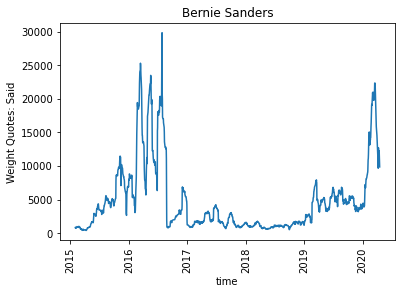

In [37]:
# For example, we can visualize the quotation changes of Bernie Sanders
candidate_quotes_byday['BERNIE SANDERS'].rolling(window=30).sum().plot() # one months average
plt.xlabel('time')
plt.xticks(rotation=90)
plt.ylabel('Weight Quotes: Said')
plt.title('Bernie Sanders')

In [38]:
# We group weighted quotations (audience views) by election day
quotes_byelection = candidate_quotes[candidate_quotes['date_only'] < candidate_quotes['election_day']]
views_byelection = pd.DataFrame(quotes_byelection.groupby(['speaker'])['normalize_views'].sum())
views_byelection.rename(columns = {'normalize_views': 'views_byelection'}, inplace=True)

Pearson coefficient: 0.6230464918664673, p value: 2.0338894729023706e-27


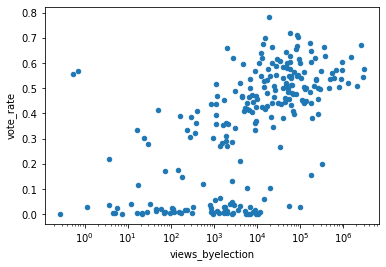

In [39]:
# We add the vote rate and plot the scatter plot of vote rate against total quotes by election
from scipy.stats import pearsonr
views_byelection['vote_rate'] = views_byelection.index.map(candidate_info_byname['vote_rate'])
views_vote = views_byelection.plot.scatter(x = 'views_byelection', y = 'vote_rate', logx=True)
(corr1, pvalue) = pearsonr(np.log(views_byelection['views_byelection']), views_byelection['vote_rate'])
print(f'Pearson coefficient: {corr1}, p value: {pvalue}')


We notice very little change in the Pearson coefficient and p-value when comparing the result to section **1.3** (where we did not weigh the quotes by website views). 

**2.4** We repeat the protocol in section **1.4** to examine the effect of weighted quotations mentioning candidates on their election results

In [40]:
# obtain normalized views by day
candidate_quotes_mention_byday = candidate_quotes_mention.groupby(['mention', 'date_only'])['normalize_views'].sum()
candidate_quotes_mention_byday

mention           date_only 
A. WAYNE JOHNSON  2015-01-16      0.406348
                  2015-08-04    153.408265
                  2015-12-11      0.644688
                  2017-02-12      1.404049
                  2017-05-28      0.270903
                                   ...    
WILLIE L. WILSON  2019-03-30      0.340118
                  2019-07-16     28.203418
                  2019-11-04     11.759805
ZAK RINGELSTEIN   2018-06-22      0.325350
                  2018-10-24      0.288297
Name: normalize_views, Length: 34904, dtype: float64

Text(0.5, 1.0, 'Bernie Sanders')

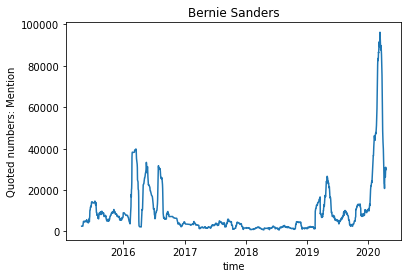

In [41]:
# For example, we can visualize the normalized view changes of Bernie Sanders
candidate_quotes_mention_byday['BERNIE SANDERS'].rolling(window=30).sum().plot() # one months average
plt.xlabel('time')
plt.ylabel('Quoted numbers: Mention')
plt.title('Bernie Sanders')

Pearson coefficient: 0.5930863043667436, p value: 4.9198504923098316e-29


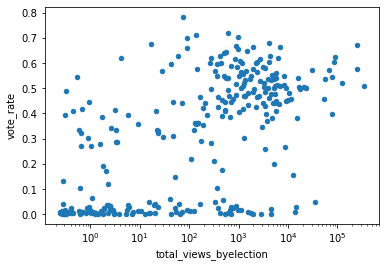

In [42]:
from scipy.stats import pearsonr

# We group the number of normalized views before election day
quotes_byelection = candidate_quotes_mention[candidate_quotes_mention['date_only'] < candidate_quotes_mention['election_day']]
tot_quotes_byelection = pd.DataFrame(quotes_byelection.groupby(['mention'])['normalize_views'].sum())
tot_quotes_byelection.rename(columns = {'normalize_views': 'total_views_byelection'}, inplace=True)

# We add the vote rate and plot the scatter plot of vote rate against total quotes by election
tot_quotes_byelection['vote_rate'] = tot_quotes_byelection.index.map(candidate_info_byname['vote_rate'])

# linear regression
quotes_vote = tot_quotes_byelection.plot.scatter(x = 'total_views_byelection', y = 'vote_rate', logx=True)
(corr1, pvalue) = pearsonr(np.log(tot_quotes_byelection['total_views_byelection']), tot_quotes_byelection['vote_rate'])
print(f'Pearson coefficient: {corr1}, p value: {pvalue}')

Again, we notice very little change in the Pearson coefficient and p-value when comparing the result to section **1.4** (where we did not weigh the quotes by website views). 

# 3. Clustering the quotation data
To answer our proposed question 3, we clustered the quotation data to find different exposure-gaining process.

We will extract feature for each senate candidate.

In [43]:
candidate_quotes['days_before_election'] = pd.to_datetime(candidate_quotes['election_day'])- pd.to_datetime(candidate_quotes['date_only'])
candidate_quotes['days_before_election'] = candidate_quotes['days_before_election'].map(lambda x:x.days)
candidate_quotes.sample(4)

,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains,normalize_factor,normalize_quotes,date_only,election_day,views,normalize_views,days_before_election
34399,34399,2015-05-22-070632,"we may not get to vote on amendments, and we m...",RAND PAUL,[Q463557],2015-05-22 22:21:27,1,"[[Rand Paul, 0.8422], [None, 0.1578]]",[http://nymag.com/daily/intelligencer/2015/05/...,E,[com],0.880164,0.880164,2015-05-22,2016-11-01,0.675,0.594111,529
296702,105118,2016-09-17-064379,To vote for a third party candidate is like a ...,GARY PETERS,"[Q1230954, Q1494930, Q5525742, Q56560036]",2016-09-17 06:45:13,1,"[[Gary Peters, 0.6603], [None, 0.3338], [Hilla...",[http://michigandaily.com/section/election/us-...,E,[com],0.395064,0.395064,2016-09-17,2020-11-01,0.675,0.266668,1506
1034164,225711,2019-07-11-097944,We should put American workers first by ensuri...,ELIZABETH A. WARREN,[Q434706],2019-07-11 16:02:54,3,"[[Elizabeth Warren, 0.6271], [None, 0.3684], [...","[http://hypervocal.com/items/2794552, http://t...",E,"[com, com, com]",0.668486,2.005458,2019-07-11,2018-11-01,84.935,56.777845,-252
794674,239732,2018-08-27-028482,"His moral courage, his perseverance and his ab...",STEVE BULLOCK,"[Q24015, Q7612088, Q7612089]",2018-08-27 18:56:21,4,"[[Steve Bullock, 0.8918], [None, 0.072], [John...",[http://krtv.com/story/38970268/mt-political-f...,E,"[com, com, com, com]",0.497688,1.990751,2018-08-27,2020-11-01,2.700,1.343757,797


In [44]:
feature_length = 300  # we use data of 100 days before the election
quotes_timespan = candidate_quotes[candidate_quotes['days_before_election']>=0]
quotes_timespan = quotes_timespan[quotes_timespan['days_before_election']<feature_length]
quotes_timespan.sample(4)

,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains,normalize_factor,normalize_quotes,date_only,election_day,views,normalize_views,days_before_election
238458,46874,2016-02-22-002948,About 70 percent of Republicans around the cou...,MARCO RUBIO,[Q324546],2016-02-22 03:04:34,1,"[[Marco Rubio, 0.4397], [None, 0.4381], [Donal...",[http://www.necn.com/news/politics/Candidates-...,E,[com],0.959534,0.959534,2016-02-22,2016-11-01,0.675,0.647685,253
1081777,44547,2020-03-26-019798,I am all for making peoples salaries whole. Ho...,LINDSEY GRAHAM,[Q22212],2020-03-26 16:31:08,1,"[[Lindsey Graham, 0.77], [None, 0.23]]",[https://dailycaller.com/2020/03/26/whoopi-gol...,E,[com],0.755660,0.755660,2020-03-26,2020-11-01,0.675,0.510070,220
778053,223111,2018-10-27-009061,Devastating news this morning. Our hearts brea...,SHERROD BROWN,[Q381880],2018-10-27 18:47:33,3,"[[Sherrod Brown, 0.8585], [None, 0.0717], [Mar...",[http://www.newsnet5.com/news/local-news/cleve...,E,"[com, com, com]",0.427106,1.281319,2018-10-27,2018-11-01,2.025,0.864890,5
594090,39148,2018-03-14-183808,You're more likely to be killed by @ timkaine ...,COREY A. STEWART,"[Q5170448, Q5170449]",2018-03-14 16:46:14,2,"[[Corey Stewart, 0.5848], [None, 0.3583], [Jas...","[http://www.c-ville.com/in-brief-8/, https://t...",E,"[com, org]",0.358144,0.716289,2018-03-14,2018-11-01,1.350,0.483495,232


In [45]:
# group the quotations by speaker
quotes_timespan_byday = quotes_timespan.groupby(['speaker', 'days_before_election'])['normalize_views'].sum()
quotes_timespan_byday

speaker           days_before_election
A. WAYNE JOHNSON  225                      0.510070
                  234                      2.040281
                  241                     11.395348
                  251                     99.717389
                  261                      2.532803
                                            ...    
ZAK RINGELSTEIN   141                      1.626749
                  147                      0.650700
                  160                      0.815621
                  227                      1.933979
                  235                      0.241747
Name: normalize_views, Length: 19165, dtype: float64

In [46]:
# build the feature vectors

candidate_name = quotes_timespan_byday.index.map(lambda x:x[0]).drop_duplicates()
candidate_quotes_cluster_feature = pd.DataFrame(np.zeros([feature_length,len(candidate_name)]), columns=candidate_name)

for candidate in candidate_name:
    candidate_quotes_timespan = quotes_timespan_byday[candidate]
    for days in candidate_quotes_timespan.index:
        candidate_quotes_cluster_feature[candidate].iloc[days] = candidate_quotes_timespan.loc[days]
        
candidate_quotes_cluster_feature

,A. WAYNE JOHNSON,AARON JAMES,ABHAY PATEL,AL GROSS,ALEX MERCED,ALLEN BUCKLEY,AMY KLOBUCHAR,AMY MCGRATH,ANN KIRKPATRICK,ARN MENCONI,...,TOM COTTON,TOM JONES,TOMMY TUBERVILLE,TONY CAMPBELL,TROY HEBERT,VALENCIA STOVALL,WENDY LONG,"WILLIAM ROBERT LANG, JR.",WILLIE L. WILSON,ZAK RINGELSTEIN
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.643107,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.607768
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.864890,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.000000,0.0,0.0,0.0,0.0,41.414354,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,3.459560
3,0.0,0.000000,0.0,0.0,0.0,0.0,4.324450,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,2.306374,0.0,0.0,0.0,0.0,0.0,0.576593
4,0.0,0.000000,0.0,0.0,0.0,0.0,4.901044,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,2.882967,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.0,0.000000,0.0,0.0,0.0,0.0,69.388074,0.000000,0.0,0.0,...,552.756030,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
296,0.0,1.169008,0.0,0.0,0.0,0.0,8.435176,0.000000,0.0,0.0,...,3.896693,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
297,0.0,0.779339,0.0,0.0,0.0,0.0,1.357593,1.169008,0.0,0.0,...,239.637971,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
298,0.0,0.779339,0.0,0.0,0.0,0.0,0.814556,0.000000,0.0,0.0,...,756.541538,0.0,191.316089,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000


Since the feature vector is 300-dimension, we will use PCA to reduce the dimension and visualize the data.

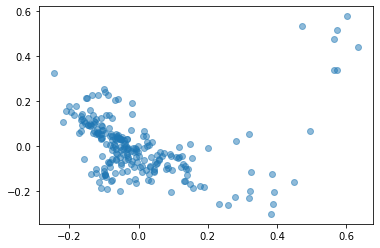

In [47]:
# Use PCA to visualize the feature vectors
from sklearn.decomposition import PCA

candidate_feature_vectors = candidate_quotes_cluster_feature.to_numpy().T
candidate_feature_vectors/=np.linalg.norm(candidate_feature_vectors,axis=1)[:,np.newaxis]
reduced_feature_PCA = PCA(n_components=2).fit(candidate_feature_vectors).transform(candidate_feature_vectors)

plt.scatter(reduced_feature_PCA[:,0],reduced_feature_PCA[:,1], alpha=0.5)

In the reduced space, we applied KMeans for clustering.

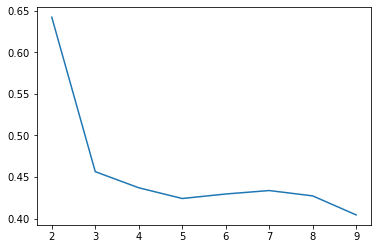

In [48]:
# find the cluster number to use

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouettes=[]
for n_clusters in range(2,10):
    labels = KMeans(n_clusters=n_clusters).fit_predict(reduced_feature_PCA)
    score = silhouette_score(reduced_feature_PCA,labels)
    silhouettes.append(score)
    
plt.plot(range(2,10),silhouettes)

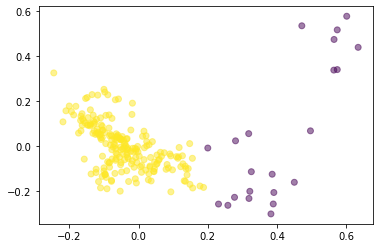

In [49]:
# based on previous result, we use 3 clusters.
n_clusters = 2
labels = KMeans(n_clusters=n_clusters).fit_predict(reduced_feature_PCA)
plt.scatter(reduced_feature_PCA[:,0],reduced_feature_PCA[:,1], alpha=0.5,c=labels)

In [50]:
# show candidates of each cluster

for candidate_type in range(0,n_clusters):
    print('{} candidates in type {}: {}'.format(np.where(labels==candidate_type)[0].shape[0],candidate_type,candidate_name[np.where(labels==candidate_type)]))

22 candidates in type 0: Index(['AMY MCGRATH', 'BEN SASSE', 'CORY BOOKER', 'CORY GARDNER',
       'DAVID A. PERDUE', 'DOUG COLLINS', 'DOUG JONES', 'GARY PETERS',
       'JEANNE SHAHEEN', 'JEFF MERKLEY', 'JOHN CORNYN', 'JON OSSOFF',
       'JONI ERNST', 'LINDSEY GRAHAM', 'MARK KELLY', 'MARK R. WARNER',
       'MITCH MCCONNELL', 'SARA I. GIDEON', 'SHELLEY MOORE CAPITO',
       'SUSAN MARGARET COLLINS', 'THOM TILLIS', 'TOM COTTON'],
      dtype='object')
212 candidates in type 1: Index(['A. WAYNE JOHNSON', 'AARON JAMES', 'ABHAY PATEL', 'AL GROSS',
       'ALEX MERCED', 'ALLEN BUCKLEY', 'AMY KLOBUCHAR', 'ANN KIRKPATRICK',
       'ARN MENCONI', 'ARVIN VOHRA',
       ...
       'TOM CONNORS', 'TOM JONES', 'TOMMY TUBERVILLE', 'TONY CAMPBELL',
       'TROY HEBERT', 'VALENCIA STOVALL', 'WENDY LONG',
       'WILLIAM ROBERT LANG, JR.', 'WILLIE L. WILSON', 'ZAK RINGELSTEIN'],
      dtype='object', length=212)


After clustering, we'd like to know how each cluster looks like. Firstly we just average the feature from each cluster and visualize them.

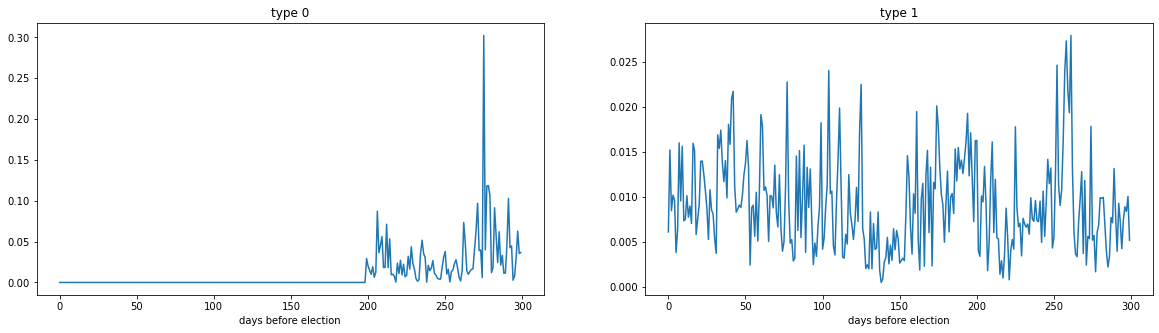

In [51]:
fig, axs = plt.subplots(1,n_clusters, figsize=(20,5))
for candidate_type in range(0,n_clusters):
    axs[candidate_type].plot(range(0,feature_length), np.mean(candidate_feature_vectors[np.where(labels==candidate_type)], axis=0))
    axs[candidate_type].set_title('type {}'.format(candidate_type))
    axs[candidate_type].set_xlabel('days before election')

We try to remove candidate of 2020 because the lack of data after April. This is shown in type 1, where we get almost no citation from roughly 200 days before election. This is mainly caused by lacking quotation data after April 2020 in the QuoteBank.

In [52]:
# find each candidates' election year.

election_year = candidate_info_byname.loc[candidate_name]['year']
election_year

A. WAYNE JOHNSON            2020
AARON JAMES                 2020
ABHAY PATEL                 2016
AL GROSS                    2020
ALEX MERCED                 2016
                            ... 
VALENCIA STOVALL            2020
WENDY LONG                  2016
WILLIAM ROBERT LANG, JR.    2016
WILLIE L. WILSON            2020
ZAK RINGELSTEIN             2018
Name: year, Length: 234, dtype: int64

In [53]:
# filt out 2020 election

candidate_name_filted = candidate_name[election_year!=2020]
candidate_name_filted

Index(['ABHAY PATEL', 'ALEX MERCED', 'ALLEN BUCKLEY', 'AMY KLOBUCHAR',
       'ANN KIRKPATRICK', 'ARN MENCONI', 'ARVIN VOHRA', 'BARRY MICHAELS',
       'BEN CARDIN', 'BERNIE SANDERS',
       ...
       'TIMOTHY M. KAINE', 'TINA SMITH', 'TODD C. YOUNG', 'TOM CONNORS',
       'TOM JONES', 'TONY CAMPBELL', 'TROY HEBERT', 'WENDY LONG',
       'WILLIAM ROBERT LANG, JR.', 'ZAK RINGELSTEIN'],
      dtype='object', length=171)

In [54]:
# rebuild our feature vectors

candidate_quotes_cluster_feature_filted = pd.DataFrame(np.zeros([feature_length,len(candidate_name_filted)]), columns=candidate_name_filted)

for candidate in candidate_name_filted:
    candidate_quotes_timespan = quotes_timespan_byday[candidate]
    for days in candidate_quotes_timespan.index:
        candidate_quotes_cluster_feature_filted[candidate].iloc[days] = candidate_quotes_timespan.loc[days]
        
candidate_quotes_cluster_feature_filted

,ABHAY PATEL,ALEX MERCED,ALLEN BUCKLEY,AMY KLOBUCHAR,ANN KIRKPATRICK,ARN MENCONI,ARVIN VOHRA,BARRY MICHAELS,BEN CARDIN,BERNIE SANDERS,...,TIMOTHY M. KAINE,TINA SMITH,TODD C. YOUNG,TOM CONNORS,TOM JONES,TONY CAMPBELL,TROY HEBERT,WENDY LONG,"WILLIAM ROBERT LANG, JR.",ZAK RINGELSTEIN
0,0.0,0.0,0.0,0.643107,0.0,0.0,0.000000,0.00000,0.964661,60.447298,...,0.0,45.258062,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.607768
1,0.0,0.0,0.0,0.864890,0.0,0.0,0.000000,0.00000,0.864890,1160.084533,...,0.0,0.576593,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,41.414354,0.0,0.0,0.000000,0.00000,3.171264,89.959246,...,0.0,45.040485,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,3.459560
3,0.0,0.0,0.0,4.324450,0.0,0.0,1.153187,0.00000,3.171264,407.068522,...,0.0,0.000000,0.0,0.0,0.0,2.306374,0.0,0.0,0.0,0.576593
4,0.0,0.0,0.0,4.901044,0.0,0.0,0.000000,0.86489,3.747857,2512.988300,...,0.0,1.441483,0.0,0.0,0.0,2.882967,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.0,0.0,0.0,69.388074,0.0,0.0,0.000000,0.00000,3464.657134,0.814556,...,0.0,1.900630,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
296,0.0,0.0,0.0,8.435176,0.0,0.0,0.000000,0.00000,1134.143035,199.262435,...,0.0,0.814556,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
297,0.0,0.0,0.0,1.357593,0.0,0.0,0.000000,0.00000,0.271519,51.317006,...,0.0,47.781231,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
298,0.0,0.0,0.0,0.814556,0.0,0.0,0.000000,0.00000,0.814556,935.498054,...,0.0,11.150362,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000


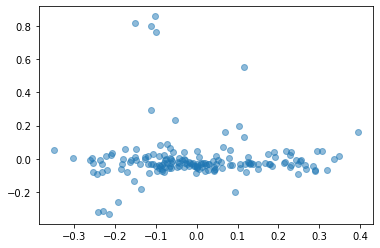

In [55]:
# PCA visualization
candidate_feature_vectors = candidate_quotes_cluster_feature_filted.to_numpy().T
candidate_feature_vectors/=np.linalg.norm(candidate_feature_vectors,axis=1)[:,np.newaxis]
reduced_feature_PCA = PCA(n_components=2).fit(candidate_feature_vectors).transform(candidate_feature_vectors)

plt.scatter(reduced_feature_PCA[:,0],reduced_feature_PCA[:,1], alpha=0.5)

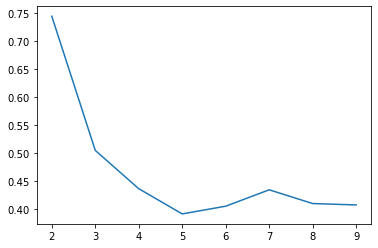

In [56]:
# find cluster number
silhouettes=[]
for n_clusters in range(2,10):
    labels = KMeans(n_clusters=n_clusters).fit_predict(reduced_feature_PCA)
    score = silhouette_score(reduced_feature_PCA,labels)
    silhouettes.append(score)
    
plt.plot(range(2,10),silhouettes)

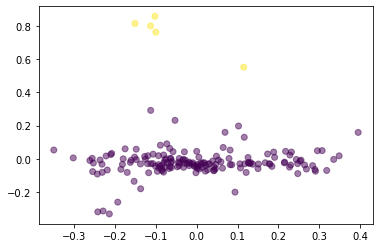

In [57]:
n_clusters = 2
labels = KMeans(n_clusters=n_clusters).fit_predict(reduced_feature_PCA)
plt.scatter(reduced_feature_PCA[:,0],reduced_feature_PCA[:,1], alpha=0.5,c=labels)

In [58]:
# again we show the candidates of each cluster
for candidate_type in range(0,n_clusters):
    print('{} candidates in type {}: {}'.format(np.where(labels==candidate_type)[0].shape[0],candidate_type,candidate_name[np.where(labels==candidate_type)]))

166 candidates in type 0: Index(['A. WAYNE JOHNSON', 'AARON JAMES', 'ABHAY PATEL', 'AL GROSS',
       'ALEX MERCED', 'ALLEN BUCKLEY', 'AMY KLOBUCHAR', 'AMY MCGRATH',
       'ANN KIRKPATRICK', 'ARN MENCONI',
       ...
       'MITCH MCCONNELL', 'MITT ROMNEY', 'MOHAMMAD "MIKE OBAMA" ARIF',
       'MURRAY SABRIN', 'NEAL SIMON', 'PATRICK "PAT" THOMAS',
       'PATRICK J. LEAHY', 'PATRICK J. TOOMEY', 'PATRICK MORRISEY',
       'PATRICK MURPHY'],
      dtype='object', length=166)
5 candidates in type 1: Index(['BOB WALSH', 'JEFF RUSSELL', 'JERRY STURGILL', 'JOHNNY ISAKSON',
       'MARK KIRK'],
      dtype='object')


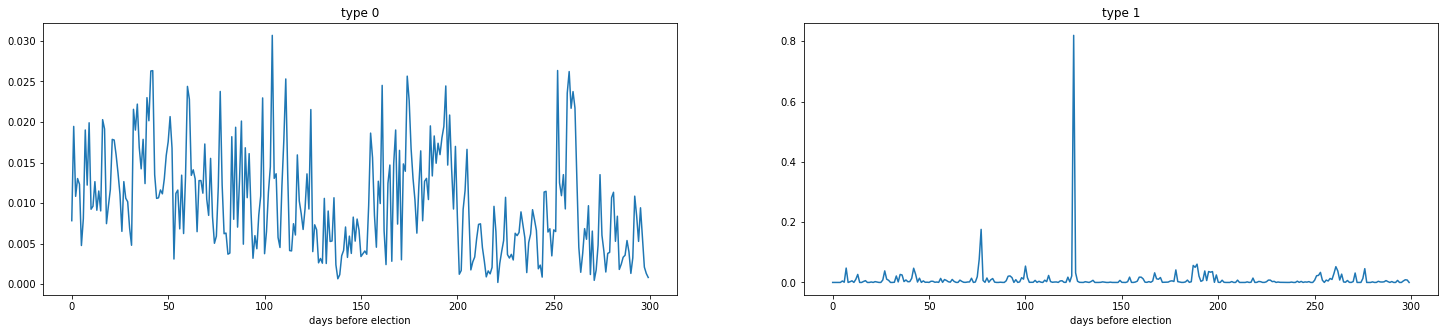

In [59]:
# use simple average to visualize the pattern of each cluster
fig, axs = plt.subplots(1,n_clusters, figsize=(25,5))
for candidate_type in range(0,n_clusters):
    axs[candidate_type].plot(range(0,feature_length), np.mean(candidate_feature_vectors[np.where(labels==candidate_type)], axis=0))
    axs[candidate_type].set_title('type {}'.format(candidate_type))
    axs[candidate_type].set_xlabel('days before election')

We also noticed that for most candidates, their quotation number of each day is relatively sparse. So it is resonable to use a longer time interval for our feature vectors. Here we sum the quotation number of each 30 days.

In [60]:
# sum for each 30 day
candidate_feature_vectors = candidate_quotes_cluster_feature_filted.to_numpy().T
candidate_feature_vectors/=np.linalg.norm(candidate_feature_vectors,axis=1)[:,np.newaxis]
candidate_feature_vectors_sum = np.array(np.split(candidate_feature_vectors,10, axis=1)).sum(axis=2).T

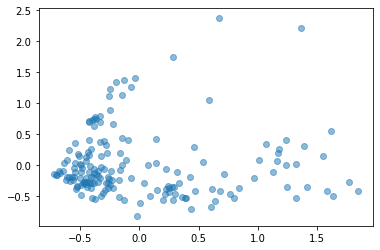

In [61]:
# PCA visualization
reduced_feature_PCA = PCA(n_components=2).fit(candidate_feature_vectors_sum).transform(candidate_feature_vectors_sum)

plt.scatter(reduced_feature_PCA[:,0],reduced_feature_PCA[:,1], alpha=0.5)

Text(0.5, 0, 'n_clusters')

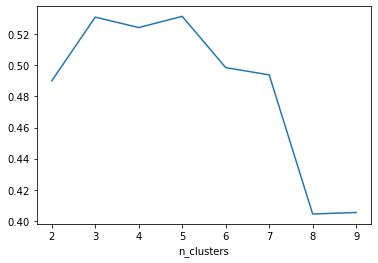

In [62]:
silhouettes=[]
for n_clusters in range(2,10):
    labels = KMeans(n_clusters=n_clusters).fit_predict(reduced_feature_PCA)
    score = silhouette_score(reduced_feature_PCA,labels)
    silhouettes.append(score)
    
plt.plot(range(2,10),silhouettes)
plt.xlabel('n_clusters')

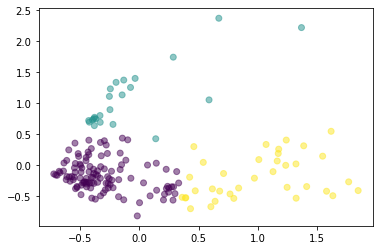

In [63]:
n_clusters = 3
labels = KMeans(n_clusters=n_clusters).fit_predict(reduced_feature_PCA)
plt.scatter(reduced_feature_PCA[:,0],reduced_feature_PCA[:,1], alpha=0.5,c=labels)

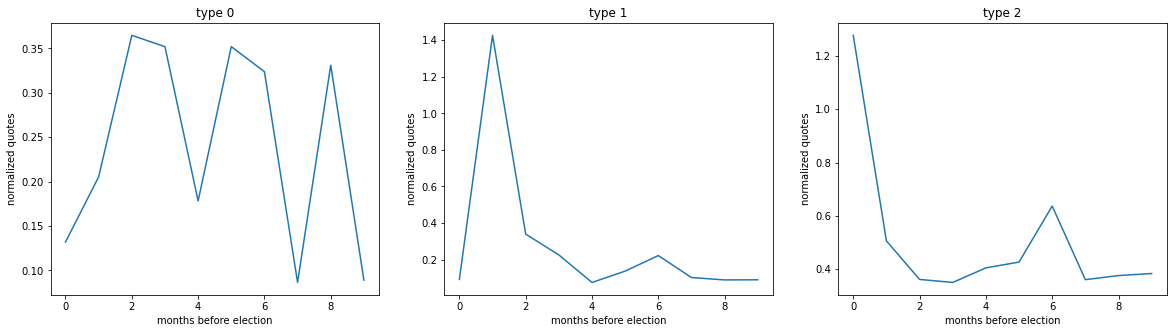

In [64]:
fig, axs = plt.subplots(1,n_clusters, figsize=(20,5))
for candidate_type in range(0,n_clusters):
    axs[candidate_type].plot(range(0,10), np.mean(candidate_feature_vectors_sum[np.where(labels==candidate_type)], axis=0))
    axs[candidate_type].set_title('type {}'.format(candidate_type))
    axs[candidate_type].set_xlabel('months before election')
    axs[candidate_type].set_ylabel('normalized quotes')

In [65]:
for candidate_type in range(0,n_clusters):
    print('{} candidates in type {}: {}'.format(np.where(labels==candidate_type)[0].shape[0],candidate_type,candidate_name_filted[np.where(labels==candidate_type)]))

112 candidates in type 0: Index(['ABHAY PATEL', 'ALEX MERCED', 'ALLEN BUCKLEY', 'ANN KIRKPATRICK',
       'ARN MENCONI', 'ARVIN VOHRA', 'BARRY MICHAELS', 'BEN CARDIN',
       'BRAD J. PEACOCK', 'BRIAN SCHATZ',
       ...
       'THOMAS R CARPER', 'TIM HAGAN', 'TIM SCOTT', 'TIMOTHY M. KAINE',
       'TOM JONES', 'TONY CAMPBELL', 'TROY HEBERT', 'WENDY LONG',
       'WILLIAM ROBERT LANG, JR.', 'ZAK RINGELSTEIN'],
      dtype='object', length=112)
23 candidates in type 1: Index(['AMY KLOBUCHAR', 'CAROLINE FAYARD', 'CATHERINE CORTEZ MASTO',
       'CHRISTOPHER S MURPHY', 'DIANNE FEINSTEIN', 'FOSTER CAMPBELL',
       'GARY E JOHNSON', 'JASON KANDER', 'JERRY STURGILL', 'JIM BARKSDALE',
       'JOHN CARROLL', 'JOHN FLEMING', 'LILY TANG WILLIAMS', 'MAZIE K. HIRONO',
       'PAUL STANTON', 'PETER WILLIAMS', 'RICHARD BLUMENTHAL',
       'RICHARD C. SHELBY', 'ROBERT T. MURPHY', 'SHELDON WHITEHOUSE',
       'STEVEN MACHAT', 'TODD C. YOUNG', 'TOM CONNORS'],
      dtype='object')
36 candidates in typ

Text(0.5, 1.0, 'Leah Vukmir, Type 0 Example')

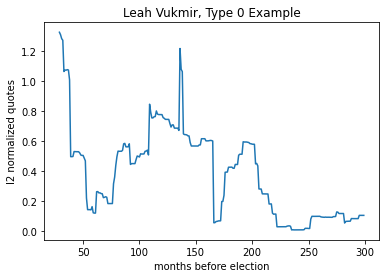

In [66]:
# From type 0
candidate_quotes_cluster_feature_filted['LEAH VUKMIR'].rolling(window=30).sum().plot()
plt.xlabel('months before election')
plt.ylabel('l2 normalized quotes')
plt.title('Leah Vukmir, Type 0 Example')

Text(0.5, 1.0, 'Tim Scott, Type 1 Example')

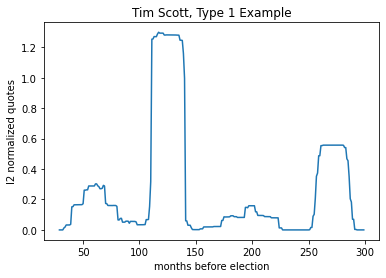

In [67]:
# From type 1
candidate_quotes_cluster_feature_filted['TIM SCOTT'].rolling(window=30).sum().plot()
plt.xlabel('months before election')
plt.ylabel('l2 normalized quotes')
plt.title('Tim Scott, Type 1 Example')

Text(0.5, 1.0, 'Jerry Sturgill, Type 2 Example')

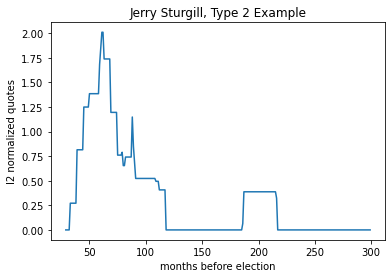

In [68]:
# From type 2
candidate_quotes_cluster_feature_filted['JERRY STURGILL'].rolling(window=30).sum().plot()
plt.xlabel('months before election')
plt.ylabel('l2 normalized quotes')
plt.title('Jerry Sturgill, Type 2 Example')

In [69]:
voterate_type0 = candidate_info_byname.loc[candidate_name_filted[np.where(labels==0)]]['vote_rate']
voterate_type1 = candidate_info_byname.loc[candidate_name_filted[np.where(labels==1)]]['vote_rate']
voterate_type2 = candidate_info_byname.loc[candidate_name_filted[np.where(labels==2)]]['vote_rate']

([<matplotlib.axis.XTick at 0x7f0958821040>,
 [Text(1, 0, 'type0'), Text(2, 0, 'type1'), Text(3, 0, 'type2')])

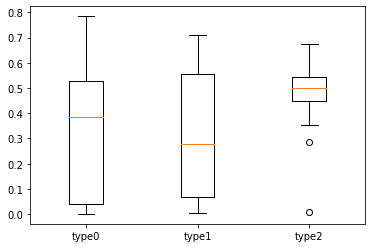

In [70]:
plt.boxplot([voterate_type0.to_numpy(),voterate_type1.to_numpy(),voterate_type2.to_numpy()])
plt.xticks([1, 2, 3], ['type0', 'type1', 'type2'])

In [71]:
from scipy.stats import ttest_ind
print(ttest_ind(voterate_type0.to_numpy(),voterate_type1.to_numpy()))
print(ttest_ind(voterate_type0.to_numpy(),voterate_type2.to_numpy()))
print(ttest_ind(voterate_type1.to_numpy(),voterate_type2.to_numpy()))

Ttest_indResult(statistic=0.3560306958024052, pvalue=0.7223816903339412)
Ttest_indResult(statistic=-3.7213043738097995, pvalue=0.0002821607767346312)
Ttest_indResult(statistic=-3.5113245160405167, pvalue=0.0008793773057030526)


The voterate of type 0 is significantly higher than other types.

# 4. Prediction Model
In this section, we will try to build the prediction model that uses the senate quotation data to predict election result.

**4.1:** First, we label the data by whether the candidate win the election in a new column 'is_winner'

In [72]:
# Add 'is_winner' feature
candidate_info['is_winner'] = False
candidate_info.loc[candidate_info.groupby(['year', 'state'])['candidatevotes'].idxmax(), 'is_winner'] = True
candidate_info[candidate_info['is_winner'] == True].head(5) # we display 5 winners

,year,state,state_po,state_fips,state_cen,state_ic,office,district,stage,special,candidate,party_detailed,writein,mode,candidatevotes,totalvotes,unofficial,version,party_simplified,is_winner
1,2016,ALABAMA,AL,1,63,41,US SENATE,statewide,gen,False,RICHARD C. SHELBY,REPUBLICAN,False,total,1335104,2087444,False,20210114,REPUBLICAN,True
7,2016,ALASKA,AK,2,94,81,US SENATE,statewide,gen,False,LISA MURKOWSKI,REPUBLICAN,False,total,138149,311441,False,20210114,REPUBLICAN,True
12,2016,ARIZONA,AZ,4,86,61,US SENATE,statewide,gen,False,JOHN MCCAIN,REPUBLICAN,False,total,1359267,2530730,False,20210114,REPUBLICAN,True
14,2016,ARKANSAS,AR,5,71,42,US SENATE,statewide,gen,False,JOHN BOOZMAN,REPUBLICAN,False,total,661984,1107522,False,20210114,REPUBLICAN,True
18,2016,CALIFORNIA,CA,6,93,71,US SENATE,statewide,gen,False,KAMALA D. HARRIS,DEMOCRAT,False,total,7542753,12244170,False,20210114,DEMOCRAT,True


We notice that the dataset also contains situation in which more than one senate are elected in a state in the same year (such situations are officialy called special senate election in the U.S.). To find these special elections, we check whether the sum of candidate votes exceed the total number of votes. 

In [73]:
# Find the special situations
sanity = candidate_info.groupby(['year', 'state'])['candidatevotes'].sum() <= candidate_info.groupby(['year', 'state'])['totalvotes'].mean()
sanity[sanity == False]

year  state      
2018  MINNESOTA      False
      MISSISSIPPI    False
2020  GEORGIA        False
dtype: bool

After manually looking at the dataset, we find two more winners: Tina Smith in 2018 Minnesota election and Cindy Hyde-Smith in 2018 MIssissippi election. The 2020 Georgia election held an additional runoff in 2021, in which Jon Ossof actually won the election. However, since QuoteBank only contains citations before April 2020, the data cannot reflect quotation changes before elections. We have decided not to include elections happening since 2020. So, we just add the two previously overlooked winners.

In [74]:
# Add winners in special elections
candidate_info.loc[candidate_info['candidate'] == 'TINA SMITH','is_winner'] = True
candidate_info.loc[candidate_info['candidate'] == 'CINDY HYDE-SMITH','is_winner'] = True

**4.2:** we now generate features by concatenating the monthly discretized quotation data (defined in clustering section above) and affiliated party information (defined below)

Since affiliated party plays an important role in election, we  include the party affiliation of each candidate. For senate elction in each state, we also consider the affiliated party's vote rate in the most recent presidential election. Since we are looking at the senate election from 2016 to 2029, we will use the 2016 presidential election data.

The presidential election data also comes from the MIT Election Data and Science Lab[2]. It contains the presidential election voting result by each state.

[2]MIT Election Data and Science Lab, 2017, "U.S. President 1976–2020", https://doi.org/10.7910/DVN/42MVDX, Harvard Dataverse, V6.

In [75]:
# We load 2016 result separately
president = pd.read_csv('SenateData/1976-2020-president.csv')
president16 = president[president['year'] == 2016].copy()
president16.sample(4) #display format of president election data

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party_detailed,writein,candidatevotes,totalvotes,version,notes,party_simplified
3731,2016,WISCONSIN,WI,55,35,25,US PRESIDENT,"DE LA FUENTE, ROQUE """"ROCKY""""",AMERICAN DELTA PARTY,False,1502,2976150,20210113,NaN,OTHER
3490,2016,ILLINOIS,IL,17,33,21,US PRESIDENT,"CLINTON, HILLARY",DEMOCRAT,False,3090729,5536424,20210113,NaN,DEMOCRAT
3638,2016,NORTH DAKOTA,ND,38,44,36,US PRESIDENT,"TRUMP, DONALD J.",REPUBLICAN,False,216794,344360,20210113,NaN,REPUBLICAN
3668,2016,RHODE ISLAND,RI,44,15,5,US PRESIDENT,"DE LA FUENTE, ROQUE """"ROCKY""""",AMERICAN DELTA PARTY,False,671,464144,20210113,NaN,OTHER


In [76]:
# We add vote rate to each candidate in each state
president16['vote_rate'] = president16['candidatevotes']/president16['totalvotes']
# We group the data by states and party_simplified (represent small parties, independent, NaN all by 'Others'). 
# We take sum of vote rates of cadidates from the same party_simplified
vote_byparty16 = president16.groupby(['state', 'party_simplified'])['vote_rate'].sum()
vote_byparty16

state      party_simplified
ALABAMA    DEMOCRAT            0.343579
           LIBERTARIAN         0.020942
           OTHER               0.014648
           REPUBLICAN          0.620831
ALASKA     DEMOCRAT            0.365509
                                 ...   
WISCONSIN  REPUBLICAN          0.472182
WYOMING    DEMOCRAT            0.216289
           LIBERTARIAN         0.051343
           OTHER               0.058384
           REPUBLICAN          0.673984
Name: vote_rate, Length: 201, dtype: float64

In [77]:
# We create feature dataframe and add in party_simplified, party vote rate in most recent presidential election, and final vote rate
# If the senate candidate's affiliated party does not show up in the most recent president election, party_vote_rate is 0
party_features = candidate_info_byname[['party_simplified']].copy()
for name in party_features.index:
    state_ = candidate_info_byname.loc[name, 'state']
    party_ = candidate_info_byname.loc[name, 'party_simplified']
    if party_ in vote_byparty16[state_].index:  #check whether the affiliated party is in recent president election
        party_features.loc[name, 'party_vote_rate'] = vote_byparty16[state_][party_]
    else: 
        party_features.loc[name, 'party_vote_rate'] = 0
        
party_features.sample(5)

,party_simplified,party_vote_rate
candidate,,
DAVID DREW KNIGHT,DEMOCRAT,0.384496
TED GIANOUTSOS,OTHER,0.062905
MARK W. TURLEY,OTHER,0.013821
"WILLIAM ROBERT LANG, JR.",OTHER,0.015900
JOHNNY ISAKSON,REPUBLICAN,0.507713


In [113]:
# We get the candidates used for model and extract the vector corresponding to affliated party's performance in last election
candidates_model = candidate_quotes_cluster_feature_filted.T.index
party_vote_model = party_features.loc[candidates_model].party_vote_rate
# We then concatenate this vector to our model
features = np.concatenate((candidate_feature_vectors_sum, party_vote_model.to_numpy()[:, np.newaxis]), axis=1)
print('we have feature vectors from {} candidates, each with dimension {}'.format(features.shape[0], features.shape[1]))

we have feature vectors from 171 candidates, each with dimension 11


In [114]:
# we also obtain the corresponding labels, with 0 meaning lose and 1 meaning win
labels = candidate_info.set_index('candidate').loc[candidates_model].is_winner.astype(int).to_numpy()
print('we have {} winner candidates and {} loser candidate'.format(sum(labels), len(labels) - sum(labels)))


we have 68 winner candidates and 103 loser candidate


In [115]:
# This helps split the data if we want to split train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=123)
print('we have {} training data and {} test data'.format(len(y_train), len(y_test)))

we have 128 training data and 43 test data


**4.3:** We build a Logistic Regression Model to predict the result

In [116]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, f1_score

We use 5-fold cross-validation on the whole dataset, to see how well logistic regression can perform on training set.

In [117]:
logistic = LogisticRegression(solver='lbfgs')
precision = cross_val_score(logistic, X_train, y_train, cv=5, scoring="precision")
recall = cross_val_score(logistic, X_train, y_train, cv=5, scoring="recall")
# Precision: avoid false positives
print("Cross-Validated Training Precision: %0.2f (+/- %0.2f)" % (precision.mean(), precision.std() * 2))
# Recall: avoid false negatives
print("Cross-Validated Training Recall: %0.2f (+/- %0.2f)" % (recall.mean(), recall.std() * 2))

Cross-Validated Training Precision: 0.72 (+/- 0.22)
Cross-Validated Training Recall: 0.43 (+/- 0.20)


Then, we train the logistic regression on the traing dataset and predict the test dataset

In [83]:
logistic = LogisticRegression(solver='lbfgs')
logistic.fit(X_train, y_train) # train the model
y_preds = logistic.predict(X_test)
accuracy = accuracy_score(y_test, y_preds)
f1 = f1_score(y_test, y_preds)
print("On the test dataset, we obtain accuracy {} and f1 score {}".format(accuracy, f1))

On the test dataset, we obtain accuracy 0.7441860465116279 and f1 score 0.6666666666666666


We then apply the XGBoost. 

In [84]:
import xgboost as xgb
# logistic = LogisticRegression(solver='lbfgs')
clf = xgb.XGBClassifier(
    n_estimators=100,
    reg_lambda=0.5,
    gamma=1,
    max_depth=1,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
precision = cross_val_score(clf, X_train, y_train, cv=5, scoring="precision")
recall = cross_val_score(clf, X_train, y_train, cv=5, scoring="recall")
# Precision: avoid false positives
print("Cross-Validated Training Precision: %0.2f (+/- %0.2f)" % (precision.mean(), precision.std() * 2))
# Recall: avoid false negatives
print("Cross-Validated Training Recall: %0.2f (+/- %0.2f)" % (recall.mean(), recall.std() * 2))

Cross-Validated Training Precision: 0.73 (+/- 0.35)
Cross-Validated Training Recall: 0.69 (+/- 0.23)


In [85]:

# read in data
clf.fit(X_train, y_train)
y_preds = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_preds)
f1 = f1_score(y_test, y_preds)
print("On the test dataset, we obtain accuracy {} and f1 score {}".format(accuracy, f1))

On the test dataset, we obtain accuracy 0.9069767441860465 and f1 score 0.9


# 5. Sentiment Analysis

In [86]:
# Obtain quotation's sentiment toward mentioned candidates
import bz2
import json
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pickle
analyzer = SentimentIntensityAnalyzer()
from collections import defaultdict


senate_candidates = list(map(lambda x:x.title(), senate_candidates))
senate_candidates_sentiment = defaultdict(list)

#candidate_quotes_mention = pd.read_pickle('SenateData/candidate_quotes_mention.pkl') 
# The above line was used to load previously stored mention data, no need to run it if you have run the above cells
candidate_quotes_mention['quotation_score'] =  candidate_quotes_mention.apply(lambda x: analyzer.polarity_scores(x['quotation'])['compound'], axis=1)
scale = candidate_quotes_mention['normalize_factor'].max() 
# we will divide the above scale factor when normalizing sentiment, to make sure the normalized sentimate still range from -1 to 1
candidate_quotes_mention['normalize_quotation_score'] = candidate_quotes_mention['quotation_score']*(candidate_quotes_mention['normalize_factor']/scale)
for index, instance in candidate_quotes_mention.iterrows():
    senate_candidates_sentiment[instance['mention']].append((instance['date'].date(), instance['quotation_score']))

# The function to extract sentiment of the sentence
def obtain_mean_sentiment(sentiment_list, time_span=None):
    # sentiment_list consists of (date, sentiment), we obtain mean sentiment in each timespan
    # time span (date_lower: str, date upper: str) 
    if time_span is None:
        return sum(map(lambda x: x[1], sentiment_list)) / len(sentiment_list)
    date_start=pd.to_datetime(time_span[0], format='%Y-%m-%d') 
    date_end=pd.to_datetime(time_span[1], format='%Y-%m-%d')
    filtered_sentiment_list = list(filter(lambda x: date_start <= pd.to_datetime(x[0], format='%Y-%m-%d')  < date_end, sentiment_list))
    return sum(map(lambda x: x[1], filtered_sentiment_list)) / max(len(filtered_sentiment_list),1)

We can visualize the sentiment changes toward each candidate over time. We take Bernie Sanders as an example.

Text(0.5, 1.0, 'Bernie Sanders')

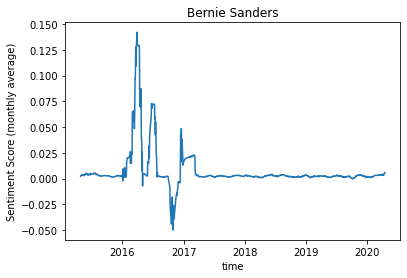

In [87]:
# Group sentiment scores by candidates and dates, average the score in each day
candidate_senti_byday = candidate_quotes_mention.groupby(['mention', 'date_only'])['normalize_quotation_score'].mean()
# Visualize the sentiment change of Bernie Sanders
candidate_senti_byday['BERNIE SANDERS'].rolling(window=30).mean().plot() # we take monthly average for better display
plt.xlabel('time')
plt.ylabel('Sentiment Score (monthly average)')
plt.title('Bernie Sanders')

We then look at the average sentiment toward each candidate within a year before the election. We can compare this to the final vote rate, so that we know whether the sentiment displayed in quotations reflect support rate.

In [88]:
# We group the quotations within 1 year before election day
quotes_byelection = candidate_quotes_mention[candidate_quotes_mention['date_only'] < candidate_quotes_mention['election_day']]
start_date = pd.to_datetime(quotes_byelection ['mention'].map(candidate_info_byname['year'] - 1).astype(str)+ '-11-01') # start date 1 yr before election
quotes_byelection = quotes_byelection[quotes_byelection['date_only'] > start_date] # all quotes within 1 year before election
# We compute the mean sentiment within that year
senti_byelection = pd.DataFrame(quotes_byelection.groupby(['mention'])['normalize_quotation_score'].mean())
senti_byelection.rename(columns = {'normalize_quotation_score': 'mean_sentiment_byelection'}, inplace=True)


Pearson coefficient: -0.10998685465657197, p value: 0.09323745970762687


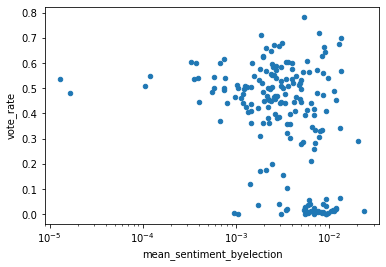

In [89]:
# We add the vote rate and plot the scatter plot of vote rate against total quotes by election
senti_byelection['vote_rate'] = senti_byelection.index.map(candidate_info_byname['vote_rate'])

# linear regression
senti_vote = senti_byelection.plot.scatter(x = 'mean_sentiment_byelection', y = 'vote_rate', logx=True)
(corr1, pvalue) = pearsonr(senti_byelection['mean_sentiment_byelection'], senti_byelection['vote_rate'])
print(f'Pearson coefficient: {corr1}, p value: {pvalue}')

We find that the p-value > 0.05. However, if we discard those which has low vote_rate (< 1%), we would find a negative relation exist in vote rate and mean sentiment.

Pearson coefficient: -0.14221865107938755, p value: 0.03996084568718259


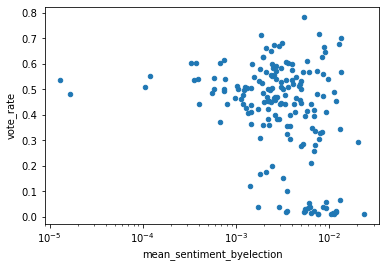

In [90]:
senti_byelection['vote_rate'] = senti_byelection.index.map(candidate_info_byname['vote_rate'])
senti_byelection = senti_byelection[senti_byelection['vote_rate'] > 0.01]
# linear regression
senti_vote = senti_byelection.plot.scatter(x = 'mean_sentiment_byelection', y = 'vote_rate', logx=True)
(corr1, pvalue) = pearsonr(senti_byelection['mean_sentiment_byelection'], senti_byelection['vote_rate'])
print(f'Pearson coefficient: {corr1}, p value: {pvalue}')

Such observation seems to be contrary to the intuition that favorable people will recieve more votes. There are two possible explaination for this: (1) the mention data are limited and the correlation is spurious. (2) Those who adopt a middle way campaign strategy will be likely to receive more votes. 

## 3. Features for Prediction Model (This is the OLD CODE)
In the proposal, we decide to build a model predicting election results based on quotation data. Here, we preprocess the quote data and candidate data to generate the features for training our model.

The first feature is the change of quotation number over time. We will also use this for clustering analysis in proposed question 3.

In [91]:
date_start=pd.to_datetime('2015-01-01', format='%Y-%m-%d') 
all_date = (pd.to_datetime('2020-12-31', format='%Y-%m-%d') - date_start).days # number of days.
candidate_quotes_name = candidate_quotes_byday.index.map(lambda x:x[0]).drop_duplicates()
candidate_quotes_feature = pd.DataFrame(np.zeros([all_date,len(candidate_quotes_name)]), columns=candidate_quotes_name) # initialize frequency vector

for candidate in candidate_quotes_name:
    candidate_mention = candidate_quotes_byday[candidate]
    for date in candidate_mention.index:
        date2days = (pd.to_datetime(date, format='%Y-%m-%d') - date_start).days # convert date to num of days w.r.t. start date
        candidate_quotes_feature[candidate].iloc[date2days] = candidate_mention.loc[date]

In [92]:
candidate_quotes_byday

speaker           date_only 
A. WAYNE JOHNSON  2015-01-06    0.601997
                  2015-02-09    0.602585
                  2015-02-11    1.205169
                  2015-02-20    0.602585
                  2015-03-01    0.535357
                                  ...   
ZAK RINGELSTEIN   2018-10-30    5.125275
                  2018-11-01    2.381878
                  2018-11-05    0.476376
                  2018-11-07    0.476376
                  2019-03-21    0.503878
Name: normalize_quotes, Length: 136070, dtype: float64

We also include the party affiliation of each candidate. Moreover, we also consider the affiliated party's vote rate in the most recent presidential election. Since we are looking at the election from 2016 to 2021, we will use the 2016 presidential election data for the senate election from 2016 to 2019, and use the 2020 presidential election data for the senate election from 2020 to 2021.

The presidential election data also comes from the MIT Election Data and Science Lab[2]. It contains the presidential election voting result by each state.

[2]MIT Election Data and Science Lab, 2017, "U.S. President 1976–2020", https://doi.org/10.7910/DVN/42MVDX, Harvard Dataverse, V6.

In [93]:
# We load 2016 and 2020 result separately
president = pd.read_csv('SenateData/1976-2020-president.csv')
president16 = president[president['year'] == 2016].copy()
president20 = president[president['year'] == 2020].copy()
president16.sample(4) #display format of president election data

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party_detailed,writein,candidatevotes,totalvotes,version,notes,party_simplified
3558,2016,MINNESOTA,MN,27,41,33,US PRESIDENT,"CLINTON, HILLARY",DEMOCRAT,False,1367705,2944782,20210113,NaN,DEMOCRAT
3577,2016,MISSOURI,MO,29,43,34,US PRESIDENT,"JOHNSON, GARY",LIBERTARIAN,False,97359,2808605,20210113,NaN,LIBERTARIAN
3438,2016,COLORADO,CO,8,84,62,US PRESIDENT,"DE LA FUENTE, ROQUE """"ROCKY""""",AMERICAN DELTA PARTY,False,1255,2780220,20210113,NaN,OTHER
3696,2016,VERMONT,VT,50,13,6,US PRESIDENT,"TRUMP, DONALD J.",REPUBLICAN,False,95369,320467,20210113,NaN,REPUBLICAN


In [94]:
# We add vote rate to each candidate in each state
president16['vote_rate'] = president16['candidatevotes']/president16['totalvotes']
president20['vote_rate'] = president20['candidatevotes']/president20['totalvotes']

In [95]:
# We group the data by states and party_simplified (represent small parties, independent, NaN all by 'Others'). 
# We take sum of vote rates of cadidates from the same party_simplified
vote_byparty16 = president16.groupby(['state', 'party_simplified'])['vote_rate'].sum()
vote_byparty20 = president20.groupby(['state', 'party_simplified'])['vote_rate'].sum()
vote_byparty16

state      party_simplified
ALABAMA    DEMOCRAT            0.343579
           LIBERTARIAN         0.020942
           OTHER               0.014648
           REPUBLICAN          0.620831
ALASKA     DEMOCRAT            0.365509
                                 ...   
WISCONSIN  REPUBLICAN          0.472182
WYOMING    DEMOCRAT            0.216289
           LIBERTARIAN         0.051343
           OTHER               0.058384
           REPUBLICAN          0.673984
Name: vote_rate, Length: 201, dtype: float64

In [96]:
# We create feature dataframe and add in party_simplified, party vote rate in most recent presidential election, and final vote rate
# If the senate candidate's affiliated party does not show up in the most recent president election, party_vote_rate is 0
features = candidate_info_byname[['party_simplified', 'vote_rate']].copy()
for name in features.index:
    state_ = candidate_info_byname.loc[name, 'state']
    party_ = candidate_info_byname.loc[name, 'party_simplified']
    if candidate_info_byname.loc[name, 'year'] < 2020: #for candidate before 2020
        if party_ in vote_byparty16[state_].index:  #check whether the affiliated party is in recent president election
            features.loc[name, 'party_vote_rate'] = vote_byparty16[state_][party_]
        else: 
            features.loc[name, 'party_vote_rate'] = 0
    else:
        if party_ in vote_byparty20[state_].index: 
            features.loc[name, 'party_vote_rate'] = vote_byparty20[state_][party_]
        else: 
            features.loc[name, 'party_vote_rate'] = 0

# 4. statistics of sentence complexity (ALSO OLD Code)

We also calculated the average length of sentence and word of each quotation. This information may be used in our analysis about speech style (question 6).

In [ ]:
# calculate average sentence length (by word number)
import re
candidate_quotes['split_quotation']=candidate_quotes.quotation.map(lambda x:re.split(r'\.|!|\?',x))
candidate_quotes['split_quotation']=candidate_quotes.split_quotation.map(lambda x:list(filter(None, x))) # remove empty string
candidate_quotes['avg_sentence_length'] = candidate_quotes.split_quotation.map(lambda x:np.mean(list(map(lambda s:len(s.split()), x))))
candidate_quotes.head(4)

In [ ]:
# calculate average word lenghth for each quotation
candidate_quotes['split_words'] = candidate_quotes.quotation.map(lambda x:x.split())
candidate_quotes['avg_word_length'] = candidate_quotes.split_words.map(lambda x:np.mean(list(map(lambda w:len(w), x))))
candidate_quotes.head(4)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains,date_only,election_day,split_quotation,avg_sentence_length,split_words,avg_word_length
0,2015-08-31-000271,... a great day for veterans here in Littleton...,JEANNE SHAHEEN,[Q270316],2015-08-31 02:10:00,2,"[[Jeanne Shaheen, 0.742], [None, 0.2359], [Kel...",[http://www.unionleader.com/article/20150831/N...,E,"[com, com]",2015-08-31,2020-11-01,[ a great day for veterans here in Littleton a...,21.500000,"[..., a, great, day, for, veterans, here, in, ...",4.318182
1,2015-10-25-000242,"' It is not now, nor has it ever been, the gol...",BERNIE SANDERS,[Q359442],2015-10-25 14:12:35,1,"[[Bernie Sanders, 0.5395], [None, 0.3128], [Hi...",[http://examiner.com/article/bernie-sanders-sl...,E,[com],2015-10-25,2018-11-01,"[' It is not now, nor has it ever been, the go...",24.333333,"[', It, is, not, now,, nor, has, it, ever, bee...",3.931507
2,2015-11-13-000427,"[ My dad ] saw what a great opportunity it was,",PAUL STANTON,"[Q255668, Q27842994]",2015-11-13 08:45:01,1,"[[Paul Stanton, 0.6521], [None, 0.3479]]",[http://thecrimson.com/article/2015/11/13/paul...,E,[com],2015-11-13,2016-11-01,"[[ My dad ] saw what a great opportunity it was,]",11.000000,"[[, My, dad, ], saw, what, a, great, opportuni...",3.363636
3,2015-06-26-015863,hurt Michigan workers and cost thousands of Am...,GARY PETERS,"[Q1230954, Q1494930, Q5525742, Q56560036]",2015-06-26 22:31:05,1,"[[Gary Peters, 0.7907], [None, 0.2093]]",[http://detroitnews.com/story/news/politics/20...,E,[com],2015-06-26,2020-11-01,[hurt Michigan workers and cost thousands of A...,10.000000,"[hurt, Michigan, workers, and, cost, thousands...",6.300000
